In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import torch
import numpy as np
import pylab as plt
import torch.nn.functional as F
import torch.nn as nn
from random_fields import *
from timeit import default_timer

In [2]:
print(torch.cuda.current_device())

0


In [3]:
# #### Parameters

# %%
res = 128-8 #resolution
npad = 8 # padding of latio 8/128 in U-NO
ntrain = 4096 # number of training samples
modes = 20 # number of Fourier modes in the initial FNO layer
d_co_domain= 32 #the dimension of the co-domain of the initial U-NO layer.
lr = 1e-4 #learning rate of the optimizer
device = 'cuda:0'
epochs = 300
λ_grad = 10.0 # Lagrange coefficinet for gradient penalty
n_critic = 10 # every n_critic iteration the generator is updated
batch_size = 32

In [4]:
# normalization, pointwise gaussian
class InputNormalizer(object):
    def __init__(self, x, eps=0.00001):
        super(InputNormalizer, self).__init__()

        # x could be in shape of ntrain*n or ntrain*T*n or ntrain*n*T
        self.mean = torch.mean(x, dim=(1,2,3)).mean(dim=0)
        self.std = torch.std(x, dim=(1,2,3)).mean(dim=0)
        self.eps = eps

    def encode(self, x):
        x = (x - self.mean) / (self.std + self.eps)
        return x

    def decode(self, x, sample_idx=None):
        if sample_idx is None:
            std = self.std + self.eps # n
            mean = self.mean
        else:
            if len(self.mean.shape) == len(sample_idx[0].shape):
                std = self.std[sample_idx] + self.eps  # batch*n
                mean = self.mean[sample_idx]
            if len(self.mean.shape) > len(sample_idx[0].shape):
                std = self.std[:,sample_idx]+ self.eps # T*batch*n
                mean = self.mean[:,sample_idx]

        # x is in shape of batch*n or T*batch*n
        x = (x * std) + mean
        return x

    def cuda(self):
        self.mean = self.mean.to(device)
        self.std = self.std.to(device)

    def cpu(self):
        self.mean = self.mean.cpu()
        self.std = self.std.cpu()

In [5]:
        
def compute_acovf(z):
    from scipy.stats import binned_statistic
    z_hat = torch.fft.rfft2(z)
    acf = torch.fft.irfft2(torch.conj(z_hat) * z_hat) / (z[0].numel())
    acf = torch.fft.fftshift(acf).mean(dim=0)
    acf_r = acf.view(-1).cpu().detach().numpy()
    lags_x, lags_y = torch.meshgrid(torch.arange(res) - res//2, torch.arange(res) - res//2)
    lags_r = torch.sqrt(lags_x**2 + lags_y**2).view(-1).cpu().detach().numpy()

    idx = np.argsort(lags_r)
    lags_r = lags_r[idx]
    acf_r = acf_r[idx]

    bin_means, bin_edges, binnumber = binned_statistic(lags_r, acf_r, 'mean', bins=np.linspace(0.0, res, 50))
    return bin_edges[:-1], bin_means


In [6]:
# ### Load the dataset

# %%
from IPython.core.display import display, HTML
display(HTML("<style>.container { d_co_domain:100% !important; }</style>"))
import glob
files = glob.glob('../datasets/InSar/*.int', recursive=True)[:ntrain]
x_train = torch.zeros(ntrain, res, res, 2).float()
for i, f in enumerate(files):
    dtype = np.float32
    nline = 128
    nsamp = 128

    with open(f, 'rb') as fn:
        load_arr = np.frombuffer(fn.read(), dtype=dtype)
        img = np.array(load_arr.reshape((nline, nsamp, -1)))

    phi = np.angle(img[:,:,0] + img[:,:,1]*1j)
    x_train[i,:,:,0] = torch.cos(torch.tensor(phi[:res, :res]))
    x_train[i,:,:,1] = torch.sin(torch.tensor(phi[:res, :res]))    


(array([ 46., 226., 305., 329., 370., 328., 214., 209., 176., 170., 146.,
        163., 136., 109., 115., 107., 118., 104.,  95.,  90., 126.,  83.,
        126., 205.]),
 array([0.        , 0.04166667, 0.08333333, 0.125     , 0.16666667,
        0.20833333, 0.25      , 0.29166667, 0.33333333, 0.375     ,
        0.41666667, 0.45833333, 0.5       , 0.54166667, 0.58333333,
        0.625     , 0.66666667, 0.70833333, 0.75      , 0.79166667,
        0.83333333, 0.875     , 0.91666667, 0.95833333, 1.        ]),
 [<matplotlib.patches.Polygon at 0x7f3d928310a0>])

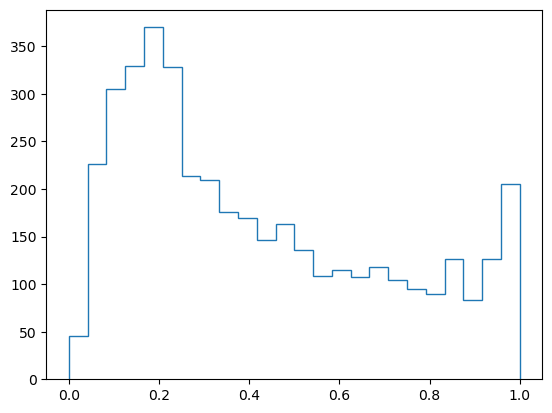

In [7]:
# ### Directional statistics
# 
# 

# %%
def circular_var(x, dim=None):
    #R = torch.sqrt((x.mean(dim=(1,2))**2).sum(dim=1))
    phase = torch.atan2(x[:,:,:,1], x[:,:,:,0])
    phase = (phase + np.pi) % (2 * np.pi) - np.pi
    
    C1 = torch.cos(phase).sum(dim=(1,2))
    S1 = torch.sin(phase).sum(dim=(1,2))
    R1 = torch.sqrt(C1**2 + S1**2) / (phase.shape[1]*phase.shape[2])
    return 1 - R1

def circular_skew(x):
    phase = torch.atan2(x[:,:,:,1], x[:,:,:,0])
    phase = (phase + np.pi) % (2 * np.pi) - np.pi
    
    C1 = torch.cos(phase).sum(dim=(1,2))
    S1 = torch.sin(phase).sum(dim=(1,2))
    R1 = torch.sqrt(C1**2 + S1**2) / (phase.shape[1]*phase.shape[2])
    
    C2 = torch.cos(2*phase).sum(dim=(1,2))
    S2 = torch.sin(2*phase).sum(dim=(1,2))
    R2 = torch.sqrt(C2**2 + S2**2) / (phase.shape[1]*phase.shape[2])
    
    T1 = torch.atan2(S1, C1)
    T2 = torch.atan2(S2, C2)

    return R2 * torch.sin(T2 - 2*T1) / (1 - R1)**(3/2)

var = circular_var(x_train)
plt.hist(var.numpy(), bins=np.linspace(0.0, 1.0, 25), histtype='step')


torch.Size([4096, 120, 120, 2])


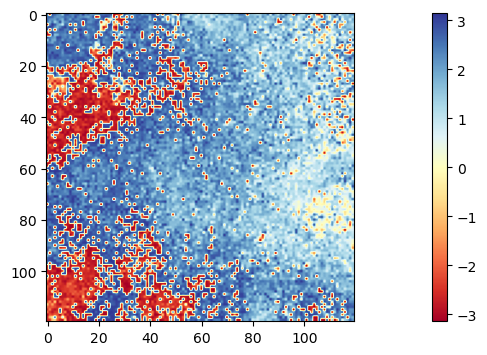

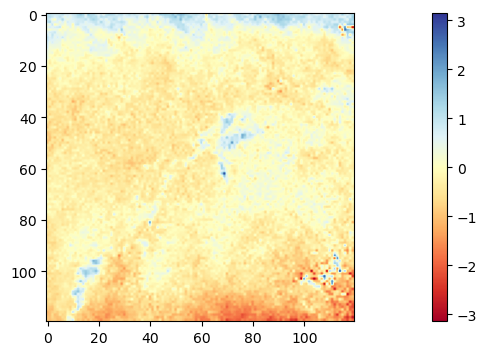

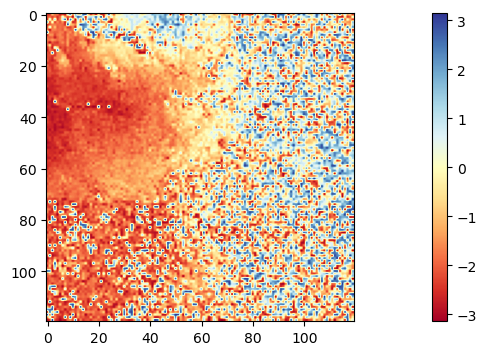

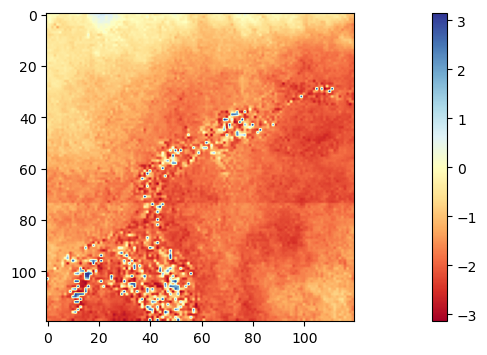

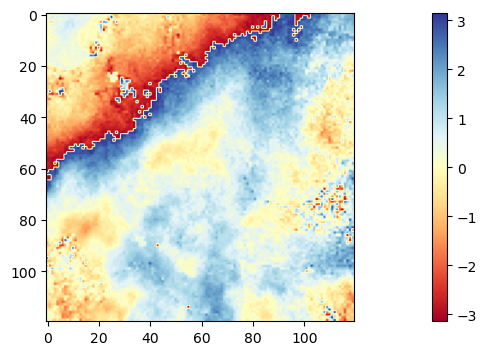

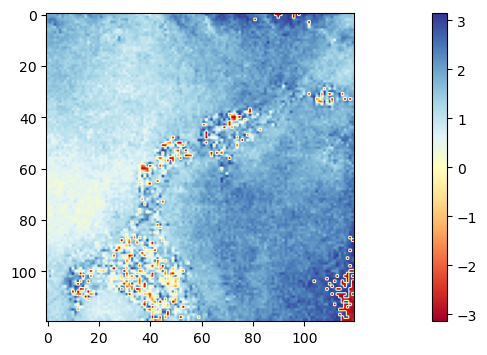

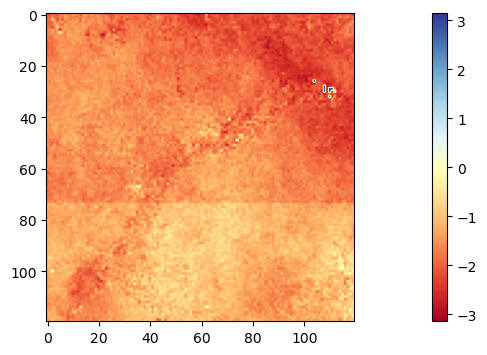

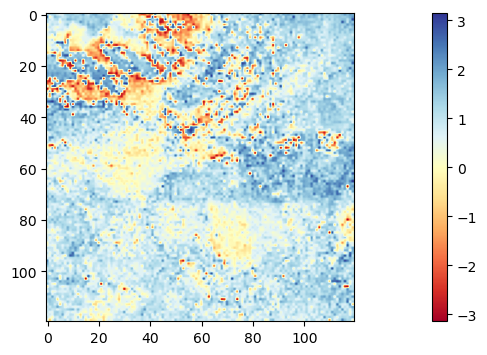

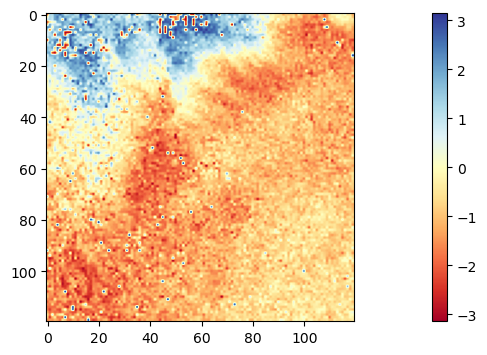

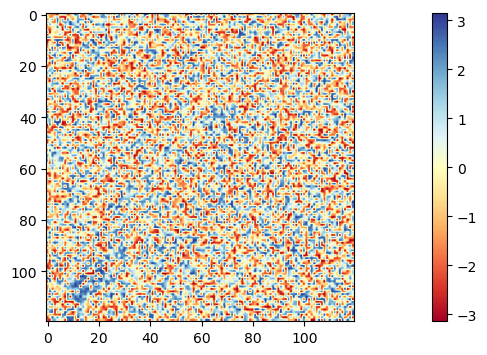

In [8]:
# ### Data visualization

# %%
print(x_train.shape)
for i in range(10):
    fig, ax = plt.subplots(1,1, figsize=(20,4))
    j = torch.randint(x_train.shape[0], size=(1,))[0]
    phase = torch.atan2(x_train[j,:,:,1], x_train[j,:,:,0]).cpu().detach().numpy()
    phase = (phase + np.pi) % (2 * np.pi) - np.pi
    bar = ax.imshow(phase,  cmap='RdYlBu', vmin = -np.pi, vmax=np.pi, interpolation=None)
    plt.colorbar(bar)
plt.show()

In [9]:
train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train), batch_size=batch_size, shuffle=True)

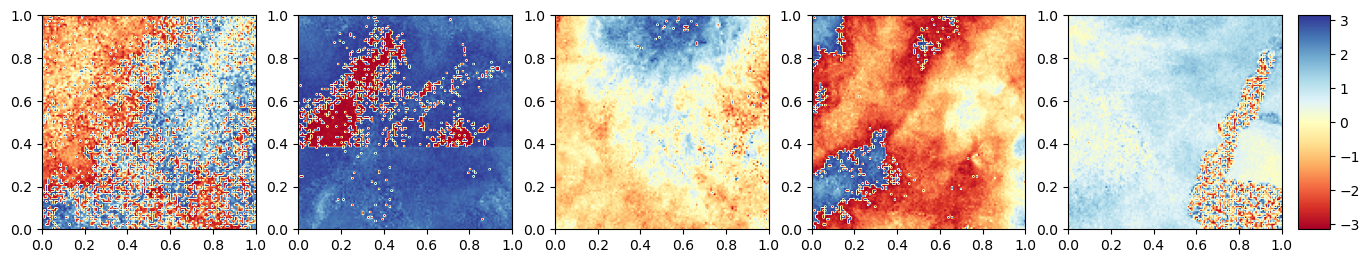

In [10]:
# ### Data visualization

# %%
numb_fig = 5
ite = 200
fig, ax = plt.subplots(1,numb_fig, figsize=(16,4))
for j in range(numb_fig):
    phase = torch.atan2(x_train[j,:,:,1], x_train[j,:,:,0]).cpu().detach().numpy()
    phase = (phase + np.pi) % (2 * np.pi) - np.pi
    bar = ax[j].imshow(phase,  cmap='RdYlBu', vmin = -np.pi, vmax=np.pi,extent=[0,1,0,1])
cax = fig.add_axes([ax[numb_fig-1].get_position().x1+0.01,ax[numb_fig-1].get_position().y0,0.02,ax[numb_fig-1].get_position().height])
plt.colorbar(bar, cax=cax) # Similar to fig.colorbar(im, cax = cax)


tensor(0., device='cuda:0') tensor(0.2663, device='cuda:0')


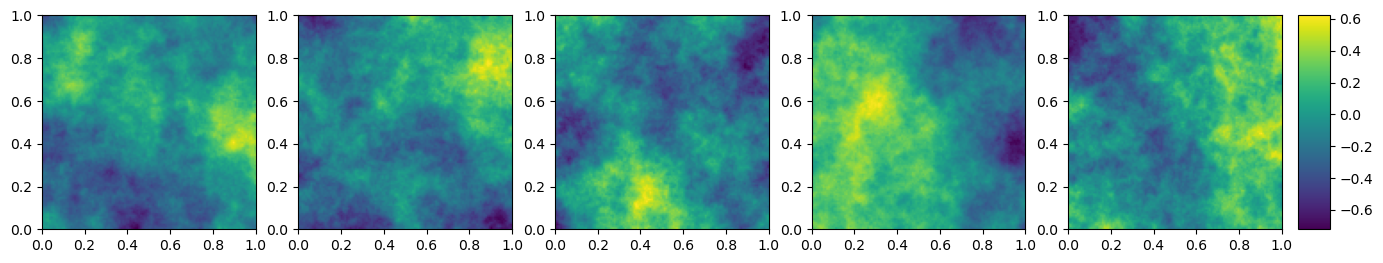

In [11]:
grf = GaussianRF_idct(2, res, alpha=1.5, tau=1.0, device=device)
numb_fig = 5
z = grf.sample(5)
print(z.mean(), z.std())
z = z.detach().cpu()
fig, ax = plt.subplots(1,numb_fig, figsize=(16,4))
for i in range(5):
    bar = ax[i].imshow(z[i], extent=[0,1,0,1])
cax = fig.add_axes([ax[numb_fig-1].get_position().x1+0.01,ax[numb_fig-1].get_position().y0,0.02,ax[numb_fig-1].get_position().height])
plt.colorbar(bar, cax=cax)


In [12]:
# ### Generator operator and Discriminator functional

# %%
class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, dim1, dim2,modes1 = None, modes2 = None):
        super(SpectralConv2d, self).__init__()

        """
        2D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """
        in_channels = int(in_channels)
        out_channels = int(out_channels)
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.dim1 = dim1 #output dimensions
        self.dim2 = dim2
        if modes1 is not None:
            self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1
            self.modes2 = modes2
        else:
            self.modes1 = dim1//2-1 #if not given take the highest number of modes can be taken
            self.modes2 = dim2//2 
        self.scale = (1 / (2*in_channels))**(1.0/2.0)
        self.weights1 = nn.Parameter(self.scale * (torch.randn(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat)))
        self.weights2 = nn.Parameter(self.scale * (torch.randn(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat)))

    # Complex multiplication
    def compl_mul2d(self, input, weights):
        # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x, dim1 = None,dim2 = None):
        if dim1 is not None:
            self.dim1 = dim1
            self.dim2 = dim2
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft2(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels,  self.dim1, self.dim2//2 + 1 , dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)

        #Return to physical space
        x = torch.fft.irfft2(out_ft, s=(self.dim1, self.dim2))
        return x


In [13]:
class pointwise_op(nn.Module):
    def __init__(self, in_channel, out_channel,dim1, dim2):
        super(pointwise_op,self).__init__()
        self.conv = nn.Conv2d(int(in_channel), int(out_channel), 1)
        self.dim1 = int(dim1)
        self.dim2 = int(dim2)

    def forward(self,x, dim1 = None, dim2 = None):
        if dim1 is None:
            dim1 = self.dim1
            dim2 = self.dim2
        x_out = self.conv(x)
        x_out = torch.nn.functional.interpolate(x_out, size = (dim1, dim2),mode = 'bicubic',align_corners=True)
        return x_out

In [14]:
def kernel(in_chan=2, up_dim=32):
    """
        Kernel network apply on grid
    """
    layers = nn.Sequential(
                nn.Linear(in_chan, up_dim, bias=True), torch.nn.GELU(),
                nn.Linear(up_dim, up_dim, bias=True), torch.nn.GELU(),
                nn.Linear(up_dim, 1, bias=False)
            )
    return layers

In [15]:
class Generator(nn.Module):
    def __init__(self, in_d_co_domain, d_co_domain, pad = 0, factor = 3/4):
        super(Generator, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: the solution of the coefficient function and locations (a(x, y), x, y)
        input shape: (batchsize, x=s, y=s, c=3)
        output: the solution 
        output shape: (batchsize, x=s, y=s, c=1)
        """
        self.in_d_co_domain = in_d_co_domain # input channel
        self.d_co_domain = d_co_domain 
        self.factor = factor
        self.padding = pad  # pad the domain if input is non-periodic

        self.fc0 = nn.Linear(self.in_d_co_domain, self.d_co_domain) # input channel is 3: (a(x, y), x, y)

        self.conv0 = SpectralConv2d(self.d_co_domain, 2*factor*self.d_co_domain, 48, 48, 24, 24)

        self.conv1 = SpectralConv2d(2*factor*self.d_co_domain, 4*factor*self.d_co_domain, 32, 32, 16,16)

        self.conv2 = SpectralConv2d(4*factor*self.d_co_domain, 8*factor*self.d_co_domain, 16, 16,8,8)
        
        self.conv2_1 = SpectralConv2d(8*factor*self.d_co_domain, 16*factor*self.d_co_domain, 8, 8,4,4)
        
        self.conv2_9 = SpectralConv2d(16*factor*self.d_co_domain, 8*factor*self.d_co_domain, 16, 16,4,4)
        

        self.conv3 = SpectralConv2d(16*factor*self.d_co_domain, 4*factor*self.d_co_domain, 32, 32,8,8)

        self.conv4 = SpectralConv2d(8*factor*self.d_co_domain, 2*factor*self.d_co_domain, 48, 48,16,16)

        self.conv5 = SpectralConv2d(4*factor*self.d_co_domain, self.d_co_domain, 64, 64,24,24) # will be reshaped

        self.w0 = pointwise_op(self.d_co_domain,2*factor*self.d_co_domain,48, 48) #
        
        self.w1 = pointwise_op(2*factor*self.d_co_domain, 4*factor*self.d_co_domain, 32, 32) #
        
        self.w2 = pointwise_op(4*factor*self.d_co_domain, 8*factor*self.d_co_domain, 16, 16) #
        
        self.w2_1 = pointwise_op(8*factor*self.d_co_domain, 16*factor*self.d_co_domain, 8, 8)
        
        self.w2_9 = pointwise_op(16*factor*self.d_co_domain, 8*factor*self.d_co_domain, 16, 16)
        
        self.w3 = pointwise_op(16*factor*self.d_co_domain, 4*factor*self.d_co_domain, 32, 32) #
        
        self.w4 = pointwise_op(8*factor*self.d_co_domain, 2*factor*self.d_co_domain, 48, 48)
        
        self.w5 = pointwise_op(4*factor*self.d_co_domain, self.d_co_domain, 64, 64) # will be reshaped

        self.fc1 = nn.Linear(2*self.d_co_domain, 4*self.d_co_domain)
        self.fc2 = nn.Linear(4*self.d_co_domain, 2)

    def forward(self, x):

        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=-1)

        x_fc0 = self.fc0(x)
        x_fc0 = F.gelu(x_fc0)
        
        x_fc0 = x_fc0.permute(0, 3, 1, 2)
        
        
        x_fc0 = F.pad(x_fc0, [0,self.padding, 0,self.padding])
        
        D1,D2 = x_fc0.shape[-2],x_fc0.shape[-1]
        

        x1_c0 = self.conv0(x_fc0,int(D1*self.factor),int(D2*self.factor))
        x2_c0 = self.w0(x_fc0,int(D1*self.factor),int(D2*self.factor))
        x_c0 = x1_c0 + x2_c0
        x_c0 = F.gelu(x_c0)
        #print(x.shape)

        x1_c1 = self.conv1(x_c0 ,D1//2,D2//2)
        x2_c1 = self.w1(x_c0 ,D1//2,D2//2)
        x_c1 = x1_c1 + x2_c1
        x_c1 = F.gelu(x_c1)
        #print(x.shape)

        x1_c2 = self.conv2(x_c1 ,D1//4,D2//4)
        x2_c2 = self.w2(x_c1 ,D1//4,D2//4)
        x_c2 = x1_c2 + x2_c2
        x_c2 = F.gelu(x_c2 )
        #print(x.shape)
        
        x1_c2_1 = self.conv2_1(x_c2,D1//8,D2//8)
        x2_c2_1 = self.w2_1(x_c2,D1//8,D2//8)
        x_c2_1 = x1_c2_1 + x2_c2_1
        x_c2_1 = F.gelu(x_c2_1)
        
        x1_c2_9 = self.conv2_9(x_c2_1,D1//4,D2//4)
        x2_c2_9 = self.w2_9(x_c2_1,D1//4,D2//4)
        x_c2_9 = x1_c2_9 + x2_c2_9
        x_c2_9 = F.gelu(x_c2_9)
        x_c2_9 = torch.cat([x_c2_9, x_c2], dim=1) 

        x1_c3 = self.conv3(x_c2_9,D1//2,D2//2)
        x2_c3 = self.w3(x_c2_9,D1//2,D2//2)
        x_c3 = x1_c3 + x2_c3
        x_c3 = F.gelu(x_c3)
        x_c3 = torch.cat([x_c3, x_c1], dim=1)

        x1_c4 = self.conv4(x_c3,int(D1*self.factor),int(D2*self.factor))
        x2_c4 = self.w4(x_c3,int(D1*self.factor),int(D2*self.factor))
        x_c4 = x1_c4 + x2_c4
        x_c4 = F.gelu(x_c4)
        x_c4 = torch.cat([x_c4, x_c0], dim=1)

        x1_c5 = self.conv5(x_c4,D1,D2)
        x2_c5 = self.w5(x_c4,D1,D2)
        x_c5 = x1_c5 + x2_c5
        x_c5 = F.gelu(x_c5)
        

        x_c5 = torch.cat([x_c5, x_fc0], dim=1)
        if self.padding!=0:
            x_c5 = x_c5[..., :-self.padding, :-self.padding]

        x_c5 = x_c5.permute(0, 2, 3, 1)
        
        x_fc1 = self.fc1(x_c5)
        x_fc1 = F.gelu(x_fc1)
        
        x_out = self.fc2(x_fc1)
        
        x_out = torch.tanh(x_out)
        
        return x_out
    
    def get_grid(self, shape, device):
        batchsize, size_x, size_y = shape[0], shape[1], shape[2]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1, 1).repeat([batchsize, 1, size_y, 1])
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, size_y, 1).repeat([batchsize, size_x, 1, 1])
        return torch.cat((gridx, gridy), dim=-1).to(device)

In [16]:
class Discriminator(nn.Module):
    def __init__(self, in_d_co_domain, d_co_domain, kernel_dim=16, pad = 0, factor = 3/4):
        super(Discriminator, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: the solution of the coefficient function and locations (a(x, y), x, y)
        input shape: (batchsize, x=s, y=s, c=3)
        output: the solution 
        output shape: (batchsize, x=s, y=s, c=1)
        """
        self.in_d_co_domain = in_d_co_domain # input channel
        self.d_co_domain = d_co_domain 
        self.factor = factor
        self.padding = pad  # pad the domain if input is non-periodic
        self.kernel_dim = kernel_dim
        self.fc0 = nn.Linear(self.in_d_co_domain, self.d_co_domain) # input channel is 3: (a(x, y), x, y)

        self.conv0 = SpectralConv2d(self.d_co_domain, 2*factor*self.d_co_domain, 48, 48, 24, 24)

        self.conv1 = SpectralConv2d(2*factor*self.d_co_domain, 4*factor*self.d_co_domain, 32, 32, 16,16)

        self.conv2 = SpectralConv2d(4*factor*self.d_co_domain, 8*factor*self.d_co_domain, 16, 16,8,8)
        
        self.conv2_1 = SpectralConv2d(8*factor*self.d_co_domain, 16*factor*self.d_co_domain, 8, 8,4,4)
        
        self.conv2_9 = SpectralConv2d(16*factor*self.d_co_domain, 8*factor*self.d_co_domain, 16, 16,4,4)
        

        self.conv3 = SpectralConv2d(16*factor*self.d_co_domain, 4*factor*self.d_co_domain, 32, 32,8,8)

        self.conv4 = SpectralConv2d(8*factor*self.d_co_domain, 2*factor*self.d_co_domain, 48, 48,16,16)

        self.conv5 = SpectralConv2d(4*factor*self.d_co_domain, self.d_co_domain, 64, 64,24,24) # will be reshaped

        self.w0 = pointwise_op(self.d_co_domain,2*factor*self.d_co_domain,48, 48) #
        
        self.w1 = pointwise_op(2*factor*self.d_co_domain, 4*factor*self.d_co_domain, 32, 32) #
        
        self.w2 = pointwise_op(4*factor*self.d_co_domain, 8*factor*self.d_co_domain, 16, 16) #
        
        self.w2_1 = pointwise_op(8*factor*self.d_co_domain, 16*factor*self.d_co_domain, 8, 8)
        
        self.w2_9 = pointwise_op(16*factor*self.d_co_domain, 8*factor*self.d_co_domain, 16, 16)
        
        self.w3 = pointwise_op(16*factor*self.d_co_domain, 4*factor*self.d_co_domain, 32, 32) #
        
        self.w4 = pointwise_op(8*factor*self.d_co_domain, 2*factor*self.d_co_domain, 48, 48)
        
        self.w5 = pointwise_op(4*factor*self.d_co_domain, self.d_co_domain, 64, 64) # will be reshaped

        self.fc1 = nn.Linear(2*self.d_co_domain, 4*self.d_co_domain)
        self.fc2 = nn.Linear(4*self.d_co_domain, 1)
        
        # kernel for last functional operation

        self.knet = kernel(2, self.kernel_dim)


    def forward(self, x):
        res1 = x.shape[1]
        res2 = x.shape[2]
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=-1)
         
        x_fc0 = self.fc0(x)
        x_fc0 = F.gelu(x_fc0)
        
        x_fc0 = x_fc0.permute(0, 3, 1, 2)
        
        
        x_fc0 = F.pad(x_fc0, [0,self.padding, 0,self.padding])
        
        D1,D2 = x_fc0.shape[-2],x_fc0.shape[-1]
        

        x1_c0 = self.conv0(x_fc0,int(D1*self.factor),int(D2*self.factor))
        x2_c0 = self.w0(x_fc0,int(D1*self.factor),int(D2*self.factor))
        x_c0 = x1_c0 + x2_c0
        x_c0 = F.gelu(x_c0)
        #print(x.shape)

        x1_c1 = self.conv1(x_c0 ,D1//2,D2//2)
        x2_c1 = self.w1(x_c0 ,D1//2,D2//2)
        x_c1 = x1_c1 + x2_c1
        x_c1 = F.gelu(x_c1)
        #print(x.shape)

        x1_c2 = self.conv2(x_c1 ,D1//4,D2//4)
        x2_c2 = self.w2(x_c1 ,D1//4,D2//4)
        x_c2 = x1_c2 + x2_c2
        x_c2 = F.gelu(x_c2 )
        #print(x.shape)
        
        x1_c2_1 = self.conv2_1(x_c2,D1//8,D2//8)
        x2_c2_1 = self.w2_1(x_c2,D1//8,D2//8)
        x_c2_1 = x1_c2_1 + x2_c2_1
        x_c2_1 = F.gelu(x_c2_1)
        
        x1_c2_9 = self.conv2_9(x_c2_1,D1//4,D2//4)
        x2_c2_9 = self.w2_9(x_c2_1,D1//4,D2//4)
        x_c2_9 = x1_c2_9 + x2_c2_9
        x_c2_9 = F.gelu(x_c2_9)
        x_c2_9 = torch.cat([x_c2_9, x_c2], dim=1) 

        x1_c3 = self.conv3(x_c2_9,D1//2,D2//2)
        x2_c3 = self.w3(x_c2_9,D1//2,D2//2)
        x_c3 = x1_c3 + x2_c3
        x_c3 = F.gelu(x_c3)
        x_c3 = torch.cat([x_c3, x_c1], dim=1)

        x1_c4 = self.conv4(x_c3,int(D1*self.factor),int(D2*self.factor))
        x2_c4 = self.w4(x_c3,int(D1*self.factor),int(D2*self.factor))
        x_c4 = x1_c4 + x2_c4
        x_c4 = F.gelu(x_c4)
        x_c4 = torch.cat([x_c4, x_c0], dim=1)

        x1_c5 = self.conv5(x_c4,D1,D2)
        x2_c5 = self.w5(x_c4,D1,D2)
        x_c5 = x1_c5 + x2_c5
        x_c5 = F.gelu(x_c5)
        

        x_c5 = torch.cat([x_c5, x_fc0], dim=1)
        if self.padding!=0:
            x_c5 = x_c5[..., :-self.padding, :-self.padding]

        x = x_c5
        x = x.permute(0, 2, 3, 1)

        x = self.fc1(x)
        x = F.gelu(x)

        x = self.fc2(x)
        
        kx = self.knet(grid)

        kx = kx.view(batch_size, -1, 1)

        x = x.view(batch_size, -1, 1)
        x = torch.einsum('bik,bik->bk', kx, x)/(res1*res2)

        return x

    def get_grid(self, shape, device):
        batchsize, size_x, size_y = shape[0], shape[1], shape[2]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1, 1).repeat([batchsize, 1, size_y, 1])
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, size_y, 1).repeat([batchsize, size_x, 1, 1])
        return torch.cat((gridx, gridy), dim=-1).to(device)


In [17]:
D = Discriminator(2+2, d_co_domain, pad=npad).to(device)
G = Generator(1+2, d_co_domain, pad=npad).to(device)
nn_params = sum(p.numel() for p in D.parameters() if p.requires_grad)
print("Number discriminator parameters: ", nn_params)
nn_params = sum(p.numel() for p in G.parameters() if p.requires_grad)
print("Number generator parameters: ", nn_params)

Number discriminator parameters:  24414001
Number generator parameters:  24413762


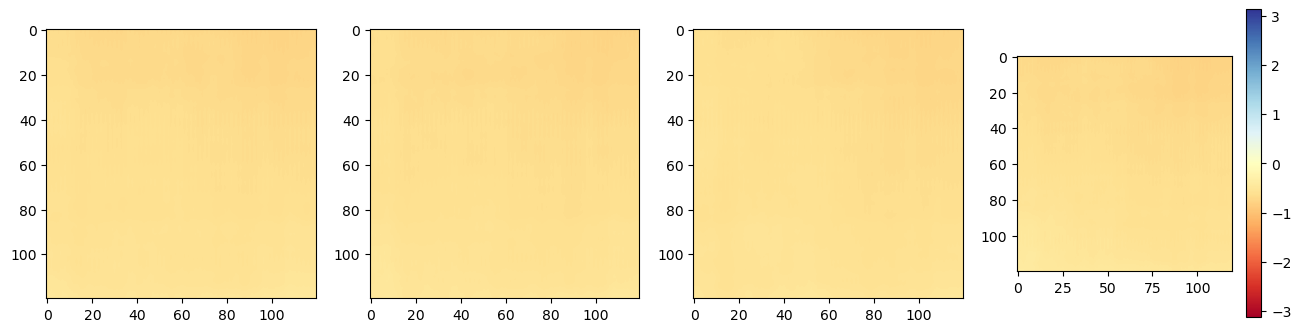

In [18]:
# ### Samples generated with initilized generator

# %%
z = grf.sample(4).unsqueeze(-1)
x = G(z)
D(x)
fig, ax = plt.subplots(1,4, figsize=(16,4))
for i in range(4):
    phase = torch.atan2(x[i,:,:,1], x[i,:,:,0]).cpu().detach().numpy()
    phase = (phase + np.pi) % (2 * np.pi) - np.pi
    bar = ax[i].imshow(phase,  cmap='RdYlBu', vmin = -np.pi, vmax=np.pi, interpolation=None)
plt.colorbar(bar)
plt.show()

In [19]:
G_optimizer = torch.optim.Adam(G.parameters(), lr=lr) #, weight_decay=1e-4)
D_optimizer = torch.optim.Adam(D.parameters(), lr=lr) #, weight_decay=1e-4)
fn_loss = nn.BCEWithLogitsLoss()

D.train()
G.train()

Generator(
  (fc0): Linear(in_features=3, out_features=32, bias=True)
  (conv0): SpectralConv2d()
  (conv1): SpectralConv2d()
  (conv2): SpectralConv2d()
  (conv2_1): SpectralConv2d()
  (conv2_9): SpectralConv2d()
  (conv3): SpectralConv2d()
  (conv4): SpectralConv2d()
  (conv5): SpectralConv2d()
  (w0): pointwise_op(
    (conv): Conv2d(32, 48, kernel_size=(1, 1), stride=(1, 1))
  )
  (w1): pointwise_op(
    (conv): Conv2d(48, 96, kernel_size=(1, 1), stride=(1, 1))
  )
  (w2): pointwise_op(
    (conv): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1))
  )
  (w2_1): pointwise_op(
    (conv): Conv2d(192, 384, kernel_size=(1, 1), stride=(1, 1))
  )
  (w2_9): pointwise_op(
    (conv): Conv2d(384, 192, kernel_size=(1, 1), stride=(1, 1))
  )
  (w3): pointwise_op(
    (conv): Conv2d(384, 96, kernel_size=(1, 1), stride=(1, 1))
  )
  (w4): pointwise_op(
    (conv): Conv2d(192, 48, kernel_size=(1, 1), stride=(1, 1))
  )
  (w5): pointwise_op(
    (conv): Conv2d(96, 32, kernel_size=(1, 1), stride

In [20]:
def calculate_gradient_penalty(model, real_images, fake_images, device):
    """Calculates the gradient penalty loss for GAN"""
    # Random weight term for interpolation between real and fake data
    alpha = torch.randn((real_images.size(0), 1, 1, 1), device=device)
    # Get random interpolation between real and fake data
    interpolates = (alpha * real_images + ((1 - alpha) * fake_images)).requires_grad_(True)

    model_interpolates = model(interpolates)
    grad_outputs = torch.ones(model_interpolates.size(), device=device, requires_grad=False)

    # Get gradient w.r.t. interpolates
    gradients = torch.autograd.grad(
        outputs=model_interpolates,
        inputs=interpolates,
        grad_outputs=grad_outputs,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.reshape(gradients.size(0), -1)
    gradient_penalty = torch.mean((gradients.norm(2, dim=1) - 1.0/res) ** 2)
    return gradient_penalty

In [21]:
def storedata(ite,G):
    high = 2
    low = 0.3
    numb_fig = 5
    fig, ax = plt.subplots(1,numb_fig, figsize=(16,4))
    for i in range(numb_fig):
        bar = ax[i].imshow(x_train[i],extent=[0,1,0,1])
#         bar.set_clim(low, high)
    cax = fig.add_axes([ax[numb_fig-1].get_position().x1+0.01,ax[numb_fig-1].get_position().y0,0.02,ax[numb_fig-1].get_position().height])
    plt.colorbar(bar, cax=cax) # Similar to fig.colorbar(im, cax = cax)

    plt.savefig('./Figures/volcano/{}GRF.pdf'.format(ite))  
    plt.show()


############################################

    with torch.no_grad():
        z = grf.sample(5*4).unsqueeze(-1)
        x = G(z)
        numb_fig = 4
        fig, ax = plt.subplots(5,numb_fig, figsize=(14,16))
        for i in range(5):
            for j in range(numb_fig):
                phase = torch.atan2(x[i*numb_fig+j,:,:,1], x[i*numb_fig+j,:,:,0]).cpu().detach().numpy()
                phase = (phase + np.pi) % (2 * np.pi) - np.pi
                bar = ax[i,j].imshow(phase,  cmap='RdYlBu', vmin = -np.pi, vmax=np.pi,extent=[0,1,0,1])
        #cax = fig.add_axes([ax[numb_fig-1].get_position().x1+0.01,ax[numb_fig-1].get_position().y0,0.02,ax[numb_fig-1].get_position().height])
        #plt.colorbar(bar, cax=cax) # Similar to fig.colorbar(im, cax = cax)
        plt.savefig('./Figures/volcano/{}GRF_GANO.pdf'.format(ite))  

        
############################################
    numb_fig = 5
    
    with torch.no_grad():
        var = torch.zeros(10000, device=device).float()
        skew = torch.zeros(10000, device=device).float()
        for j in range(10000//100):
            z = grf.sample(100).unsqueeze(-1)
            x = G(z)
            var[j*100:(j+1)*100] = circular_var(x)
            skew[j*100:(j+1)*100] = circular_skew(x)
        
    var_train = circular_var(x_train)
    skew_train = circular_skew(x_train)

    fig, ax = plt.subplots(1,1, figsize=(4,4),tight_layout=True)
    ax.hist(var_train.cpu().detach().numpy(), bins=np.linspace(0.0, 1.0, 50), histtype='step', density=True, color='#ff7f0e', label='Ground truth')
    ax.hist(var.view(-1).cpu().detach().numpy(), bins=np.linspace(0.0, 1.0, 50), color='#1f77b4' , histtype='step', density=True, label='GANO')
    ax.set_xlim(0.0, 1.0)
    # ax[1].plot(lags_ref, acf_ref, c='r')
    # ax[1].plot(lags, acf, c='k')
    plt.xlabel('value')
    # plt.title('Histogram')
    plt.ylabel('Histogram')

    plt.legend()

    plt.savefig('./Figures/volcano/{}GRF_varianceGANO.pdf'.format(ite))  

    fig, ax = plt.subplots(1,1, figsize=(4,4),tight_layout=True)
    ax.hist(skew_train.cpu().detach().numpy(), bins=np.linspace(-4.0, 4.0, 50), histtype='step', density=True, color='#ff7f0e', label='Ground truth')
    ax.hist(skew.view(-1).cpu().detach().numpy(), bins=np.linspace(-4.0, 4.0, 50), color='#1f77b4' , histtype='step', density=True, label='GANO')
    plt.xlabel('value')
    plt.ylabel('Histogram')
    ax.set_xlim(-4.0, 4.0)
    # plt.title('Auto correlation')
    plt.legend()
    plt.savefig('./Figures/volcano/{}GRF_skewnessGANO.pdf'.format(ite))
    
    plt.close('all')


In [22]:
def train_GANO(D, G, train_data, epochs, D_optim, G_optim, scheduler=None):
    losses_D = np.zeros(epochs)
    losses_G = np.zeros(epochs)
    losses_W = np.zeros(epochs)
    start_time = default_timer()
    for i in range(epochs):
        loss_D = 0.0
        loss_G = 0.0
        loss_W = 0.0
        t1 = default_timer()
        for j, data in enumerate(train_data):
            # Train D
            x = data[0].to(device)
            D_optim.zero_grad()

            x_syn = G(grf.sample(x.shape[0]).unsqueeze(-1))
            
            W_loss = -torch.mean(D(x)) + torch.mean(D(x_syn.detach()))

            gradient_penalty = calculate_gradient_penalty(D, x.data, x_syn.data, device)

            loss = W_loss + λ_grad * gradient_penalty
            loss.backward()

            loss_D += loss.item()
            loss_W += W_loss.item()

            D_optim.step()
            
            # Train G
            if (j + 1) % n_critic == 0:
                G_optim.zero_grad()

                x_syn = G(grf.sample(x.shape[0]).unsqueeze(-1))

                loss = -torch.mean(D(x_syn))
                loss.backward()
                loss_G += loss.item()

                G_optim.step()
        print(j)
        losses_D[i] = loss_D / batch_size
        losses_G[i] = loss_G / batch_size
        losses_W[i] = loss_W / batch_size
            
        t2 = default_timer()

        print(i, t2-t1, losses_D[i], losses_G[i], losses_W[i])
    torch.save(D.state_dict(), "./models/volcano/D.pt".format())
    torch.save(G.state_dict(), "./models/volcano/G.pt".format())

    # storedata(i, G)t2 = default_timer()
    end_time = default_timer()
    total_time = end_time - start_time
    print("Total time %f"%total_time)
    return losses_D, losses_G, losses_W

In [23]:
# losses_D, losses_G, losses_W = train_GANO(D, G, train_loader, epochs, D_optimizer, G_optimizer)
G.load_state_dict(torch.load("models/volcano/G.pt".format()))

<All keys matched successfully>

In [24]:
# %%
# fig, ax = plt.subplots(1,1, figsize=(6,4),tight_layout=True)
# ax.plot(np.arange(epochs), losses_D, c='k', label='D')
# ax.plot(np.arange(epochs), losses_G, c='b', label='G')
# plt.legend(loc = 'lower right')
# plt.ylabel("Loss")
# plt.xlabel("Epoch")
# plt.xlim(0.0, 300.0)
# plt.savefig("./Figures/volcano/volcano_losses.png")

In [25]:
G.load_state_dict(torch.load("models/volcano/G.pt".format()))


num_samples = 4096
batch_size = 4
num_steps = num_samples // batch_size
samples = torch.zeros(num_samples, 120, 120, 2).float()
for i in range(num_steps):
    z = grf.sample(batch_size).unsqueeze(-1)
    samples[i*batch_size:(i+1)*batch_size,...] = G(z)

print(samples.shape)

var_gt = circular_var(x_train)
var_gen = circular_var(samples)
plt.hist(var_gt.numpy(), bins=np.linspace(0.0, 1.0, 25), histtype='step')
plt.hist(var_gen.numpy(), bins=np.linspace(0.0, 1.0, 25), histtype='step')

OutOfMemoryError: CUDA out of memory. Tried to allocate 14.00 MiB (GPU 0; 47.54 GiB total capacity; 46.07 GiB already allocated; 8.19 MiB free; 46.89 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

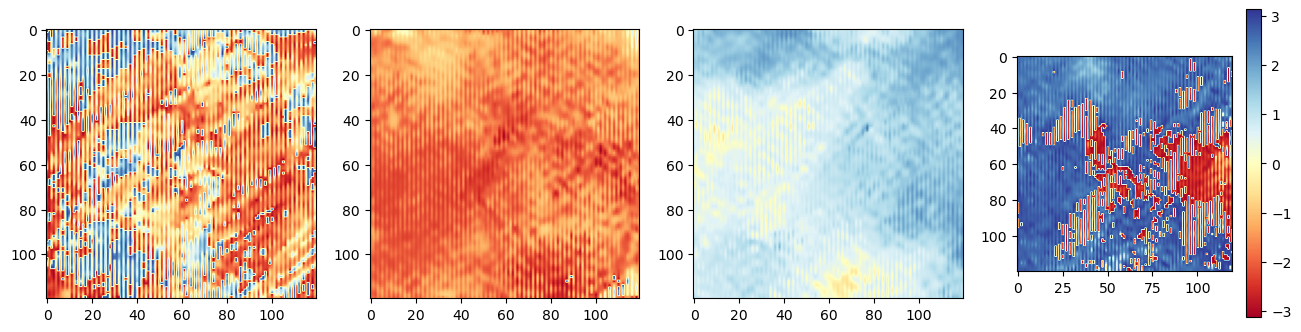

In [ ]:
z = grf.sample(4).unsqueeze(-1)
x = G(z)

fig, ax = plt.subplots(1,4, figsize=(16,4))
for i in range(4):
    phase = torch.atan2(x[i,:,:,1], x[i,:,:,0]).cpu().detach().numpy()
    phase = (phase + np.pi) % (2 * np.pi) - np.pi
    bar = ax[i].imshow(phase,  cmap='RdYlBu', vmin = -np.pi, vmax=np.pi, interpolation=None)
plt.colorbar(bar)
plt.show()